In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

ModuleNotFoundError: No module named 'pandas'

In [58]:
def get_stock_data(ticker):
    df = yf.download(ticker, period='max')
    return df[['Close']]

In [59]:
data = get_stock_data('AAPL')

/tmp/ipython-input-58-3058989642.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period='max')
[*********************100%***********************]  1 of 1 completed


In [60]:
clean_data = data.reset_index()

In [62]:
clean_data.dropna(inplace=True)

In [63]:
clean_data.head()

Price,Date,Close
Ticker,,AAPL
0,1980-12-12,0.098597
1,1980-12-15,0.093453
2,1980-12-16,0.086594
3,1980-12-17,0.088737
4,1980-12-18,0.091310


In [18]:
df = clean_data[['Date', 'Close']]

df

Price,Date,Close
Ticker,,MSFT
0,1986-03-13,0.059598
1,1986-03-14,0.061726
2,1986-03-17,0.062791
3,1986-03-18,0.061194
4,1986-03-19,0.060130
...,...,...
9889,2025-06-12,478.869995
9890,2025-06-13,474.959991
9891,2025-06-16,479.140015


In [24]:
df.index = df.pop('Date')
df

Price,Close
Ticker,MSFT
Date,
1986-03-13,0.059598
1986-03-14,0.061726
1986-03-17,0.062791
1986-03-18,0.061194
1986-03-19,0.060130
...,...
2025-06-12,478.869995
2025-06-13,474.959991


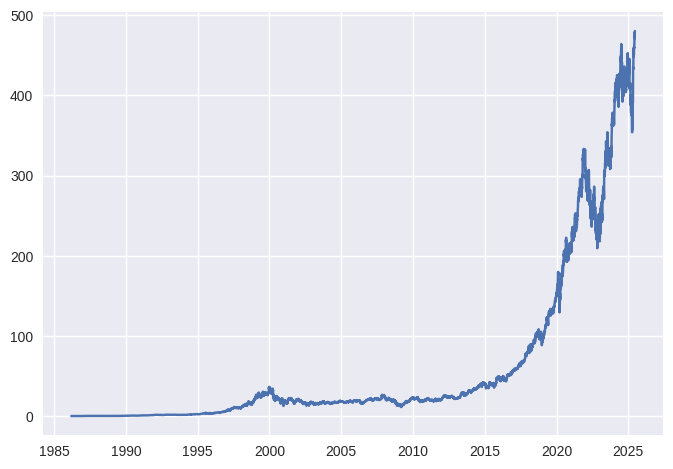

In [48]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
plt.plot(df.index, df['Close'])

In [31]:
import numpy as np
import pandas as pd

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    dataframe = dataframe.copy()
    dataframe = dataframe.sort_index()

    if not isinstance(dataframe.index, pd.DatetimeIndex):
        dataframe.index = pd.to_datetime(dataframe.index)

    first_date = pd.to_datetime(first_date_str)
    last_date = pd.to_datetime(last_date_str)

    dates = []
    X, Y = [], []

    valid_dates = dataframe.loc[first_date:last_date].index

    for i in range(n, len(valid_dates)):
        window = dataframe.loc[valid_dates[i - n:i + 1]]
        if len(window) < n + 1:
            continue

        x = window['Close'].iloc[:-1].to_numpy()
        y = window['Close'].iloc[-1]

        dates.append(valid_dates[i])
        X.append(x)
        Y.append(y)

    if len(X) == 0:
        raise ValueError("No valid windowed data found. Try changing the date range or reducing `n`.")

    X = np.array(X)
    Y = np.array(Y)

    ret_df = pd.DataFrame({'Target Date': dates})

    for i in range(n):
        ret_df[f'Target-{n-i}'] = X[:, i]

    ret_df['Target'] = Y
    return ret_df


In [32]:
windowed_df = df_to_windowed_df(df,
                                '2021-03-25',
                                '2022-03-23',
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-30,224.239166,228.234818,227.038055,223.766281
1,2021-03-31,228.234818,227.038055,223.766281,227.549576
2,2021-04-01,227.038055,223.766281,227.549576,233.900162
3,2021-04-05,223.766281,227.549576,233.900162,240.385864
4,2021-04-06,227.549576,233.900162,240.385864,239.218063
...,...,...,...,...,...
244,2022-03-17,268.974762,279.395569,286.440125,287.247681
245,2022-03-18,279.395569,286.440125,287.247681,292.316956
246,2022-03-21,286.440125,287.247681,292.316956,291.081268
247,2022-03-22,287.247681,292.316956,291.081268,295.848907


In [33]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((249,), (249, 3, 1), (249,))

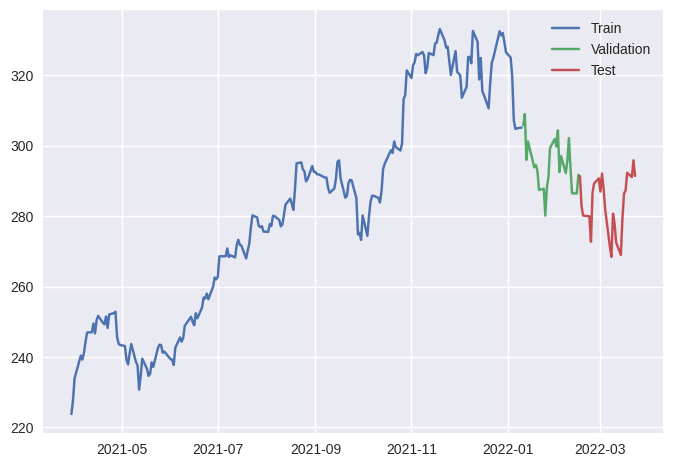

In [49]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 78935.7578 - mean_absolute_error: 279.2906 - val_loss: 86750.7578 - val_mean_absolute_error: 294.4561
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 79767.6953 - mean_absolute_error: 280.8537 - val_loss: 86485.1094 - val_mean_absolute_error: 294.0046
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 78773.3203 - mean_absolute_error: 279.0693 - val_loss: 86114.9922 - val_mean_absolute_error: 293.3745
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 80352.1172 - mean_absolute_error: 281.8862 - val_loss: 85656.3828 - val_mean_absolute_error: 292.5919
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 77691.5469 - mean_absolute_error: 277.0210 - val_loss: 85063.4688 - val_mean_absolute_error: 291.5769
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 78317.9453 - mean_absolute_error: 278.1249 - val_loss: 84211.0781 - val_mean_absolute_error: 290.1115
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


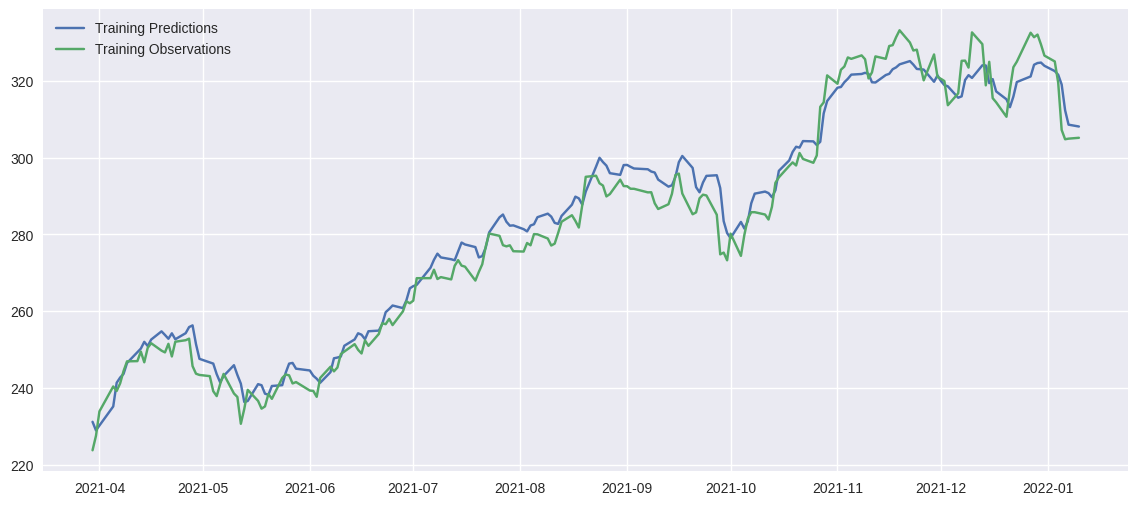

In [51]:
train_predictions = model.predict(X_train).flatten()
plt.figure(figsize=(14, 6))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


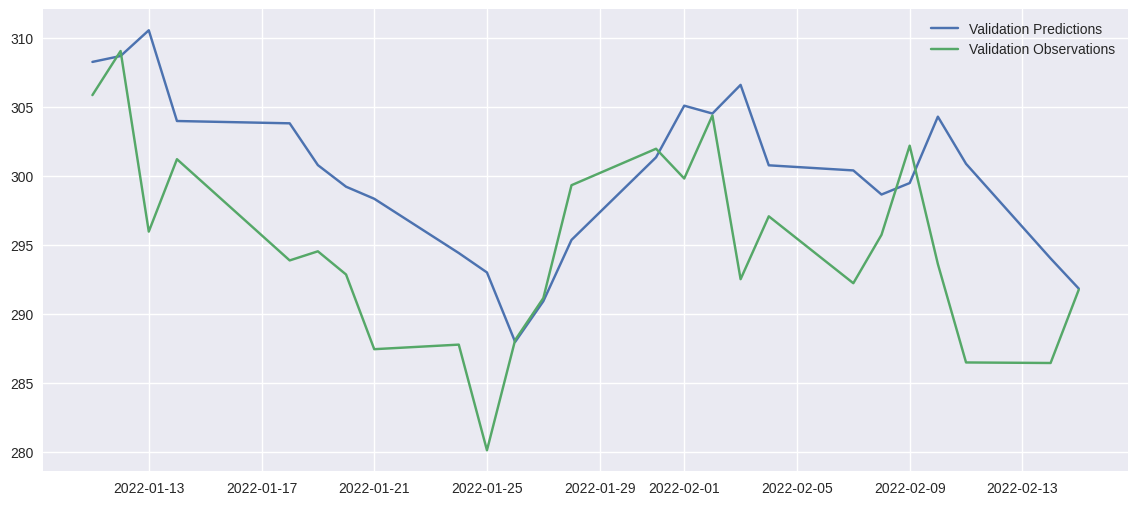

In [52]:
val_predictions = model.predict(X_val).flatten()
plt.figure(figsize=(14, 6))
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


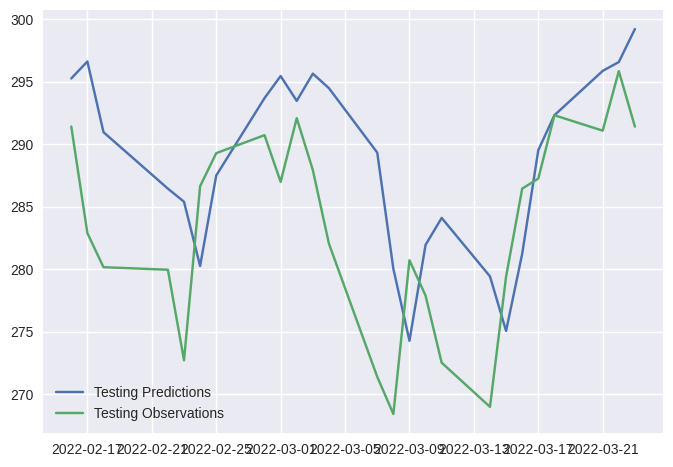

In [53]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

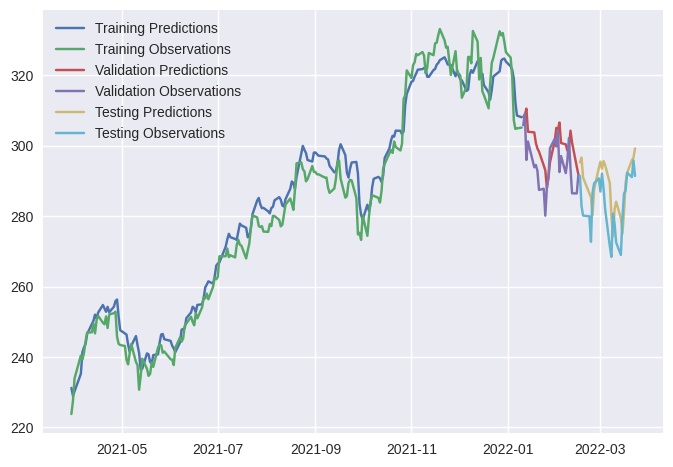

In [54]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

In [42]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━

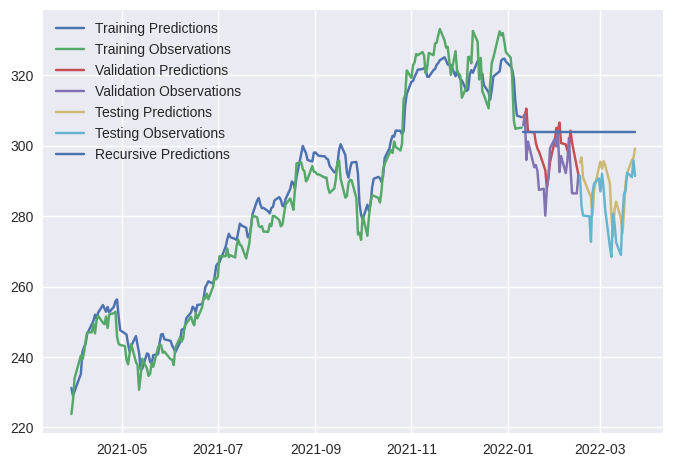

In [55]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions'])